In [1]:
%matplotlib inline
from imports import *
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)
minorLocator   = MultipleLocator(2)

# Load installed sources

In [2]:
sources = pd.read_csv('../../data/for_analysis/installed_packages.csv',
                      usecols=['image','source','source_version','release','last_updated','type'], dtype=object)
sources.shape

(46272487, 6)

In [3]:
sources.drop_duplicates(inplace=True)
sources.shape

(25953301, 6)

In [4]:
sources = sources.query('last_updated!= "None"').copy()
sources['last_updated'] = pd.to_datetime(sources['last_updated'])
sources.shape

(25952909, 6)

# Load bugs dataset

In [5]:
bugs = pd.read_csv('../../data/for_analysis/vb_lag_ideal.csv',
                      usecols=['source',
                               'source_version',
                               'archive',
                               'last_updated',
                               'Higher','Lower',
                               'l_Higher','l_Lower'])
bugs.shape

(1222801, 8)

In [6]:
bugs = bugs.query('last_updated!= "None"').copy()
bugs['last_updated'] = pd.to_datetime(bugs['last_updated'])

In [7]:
sources = (sources
        .merge(bugs
               .rename(columns={'archive':'release'}),
               on = ['source','source_version','last_updated','release'],
               how = 'left')
       )
sources.shape

(25952909, 10)

In [8]:
sources.replace({'type': type_map}, inplace=True)
sources.replace({'release': release_map}, inplace=True)

In [9]:
sources.drop(['source','source_version'], axis=1, inplace=True)

In [10]:
sources.fillna(0, inplace=True)

In [11]:
sources = sources.groupby(['image','release','type','last_updated']).agg(sum).reset_index()

In [12]:
sources.head(2)

,image,release,type,last_updated,Higher,Lower,l_Higher,l_Lower
0,010309:mmmiddleware:0.9.25,Stable,community,2017-11-01,545.0,2695.0,545.0,2695.0
1,010309:mmmiddleware:0.9.26,Stable,community,2017-11-12,543.0,2690.0,543.0,2690.0


In [13]:
image_bugs = (sources
              .assign(cve= lambda d: d['Higher'] + d['Lower'])
              .assign(l_cve= lambda d: d['l_Higher'] + d['l_Lower'])
            )
image_bugs.shape

(140496, 10)

## Let's see how many bugs exist per image

In [14]:
for x in ['Oldstable','Stable','Testing']:
    for t in ['official', 'community']:
        print(x, t)
        print(image_bugs.query('type =="'+t+'" and release=="'+x+'"').cve.mean(),
              image_bugs.query('type =="'+t+'" and release=="'+x+'"').cve.median(),
              image_bugs.query('type =="'+t+'" and release=="'+x+'"').cve.max())

Oldstable official
5140.436628849271 5126.0 7857.0
Oldstable community
6490.735366921817 6916.0 11523.0
Stable official
5216.921693313953 5173.0 8819.0
Stable community
6300.351033971457 6111.0 14269.0
Testing official
4372.114709851552 4894.0 7323.0
Testing community
6269.21997430957 6342.0 10653.0


In [15]:
for t in ['official', 'community']:
    print(t)
    print(image_bugs.query('type =="'+t+'"').cve.mean(),
          image_bugs.query('type =="'+t+'"').cve.median(),
          image_bugs.query('type =="'+t+'"').cve.max())

official
5124.536012861737 5127.0 8819.0
community
6375.8405836878455 6700.0 14269.0


In [16]:
# Mann-whitney u test
print(scipy.stats.mannwhitneyu(image_bugs.query('type=="community"').cve, 
        image_bugs.query('type=="official"').cve))

MannwhitneyuResult(statistic=320422152.0, pvalue=0.0)


In [17]:
import effect_size
# Mann-whitney u test
print(effect_size.cliffsDelta(image_bugs.query('type=="official"').cve, 
        image_bugs.query('type=="community"').cve))

d=-0.4763397482672481
True


In [18]:
# Mann-whitney u test
for x in [['Oldstable','Stable'], ['Oldstable','Testing'], ['Stable','Testing']]:
    print(x,scipy.stats.mannwhitneyu(image_bugs.query('release=="'+x[0]+'"').cve, 
            image_bugs.query('release=="'+x[1]+'"').cve))

['Oldstable', 'Stable'] MannwhitneyuResult(statistic=2023778362.0, pvalue=5.84746494712558e-225)
['Oldstable', 'Testing'] MannwhitneyuResult(statistic=90336091.0, pvalue=2.576333253769303e-60)
['Stable', 'Testing'] MannwhitneyuResult(statistic=139841479.5, pvalue=1.822837942082274e-28)


In [19]:
# Mann-whitney u test
for x in [['Oldstable','Stable'], ['Oldstable','Testing'], ['Stable','Testing']]:
    print(x,effect_size.cliffsDelta(image_bugs.query('release=="'+x[0]+'"').cve, 
            image_bugs.query('release=="'+x[1]+'"').cve))

d=0.10173184086771782
['Oldstable', 'Stable'] False
d=0.15711430531711132
['Oldstable', 'Testing'] True
d=0.1047323141768626
['Stable', 'Testing'] False


## The evolution of the number of image bugs in time

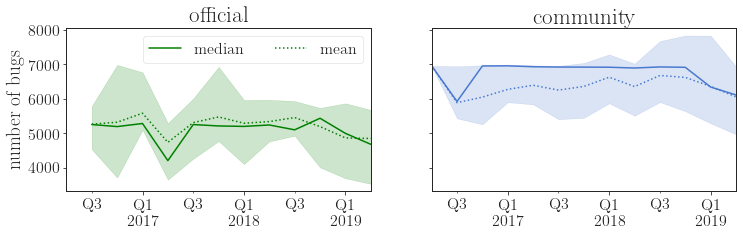

In [22]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(12,3)
for index, genre in enumerate(['official','community']):
    size=[12,20,70]
    df_=(image_bugs.
         query('type=="{}"'.format(genre)).
         groupby(pd.Grouper(key='last_updated', freq='1Q'))['cve'].
         describe()[['mean', '25%', '50%', '75%']] 
        )

    df_tmp=df_
    df_tmp['50%'].rename('median').plot(ax=axes[index], color=colors[genre])
    ax=df_tmp['mean'].plot(ax=axes[index],style=':',color=colors[genre])
    ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], alpha=0.2, color=colors[genre])
    
    ax.set(
        xlabel='',
        ylabel='number of bugs',
        title=genre)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.legend(prop={'size': 16}, ncol=2) 
ax.legend('').remove()


In [20]:
print(image_bugs.Higher.median(), 
  image_bugs.Lower.median())

1672.0 4815.0


In [24]:
image_bugs.cve.median()

6483.0

## The evolution of the number of image bugs in time, grouped by bug urgency

/home/neglectos/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


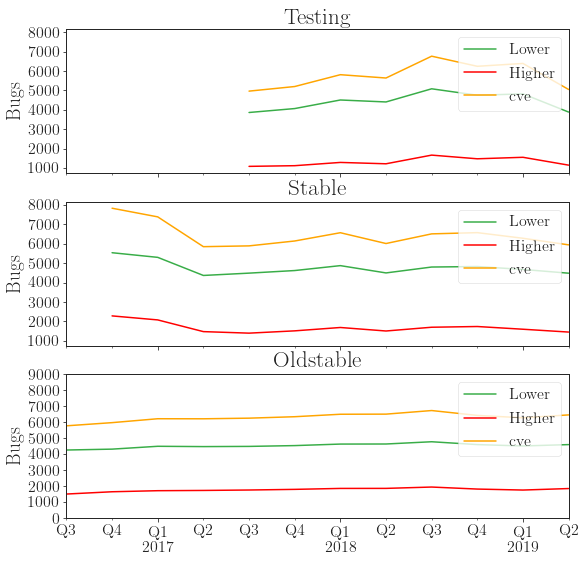

In [24]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True)
fig.set_size_inches(9,9)
for j, release in enumerate(['Testing','Stable','Oldstable']):
    df_=(image_bugs.
         query('release =="{}"'.format(release)).
         groupby(pd.Grouper(key='last_updated', freq='1Q'))[['Lower','Higher','cve']].
         mean()
        )
    color = colors[release]
    
    ax=df_.plot(ax=axes[j], colors=[colors[x] for x in ['Lower','Higher','Medium']])

    ax.set(
        xlabel='',
        ylabel='Bugs',
        title=release.capitalize(),    
        xlim=date_period)
    ax.legend(loc='upper right',  prop={'size': 16, 'weight':'bold'})
    plt.yticks(pd.np.arange(0, 10000, 1000))


# We compute bug lag and analyze it

In [22]:
# Compute the lag
image_bugs['cve_lag'] = image_bugs['cve'] - image_bugs['l_cve']

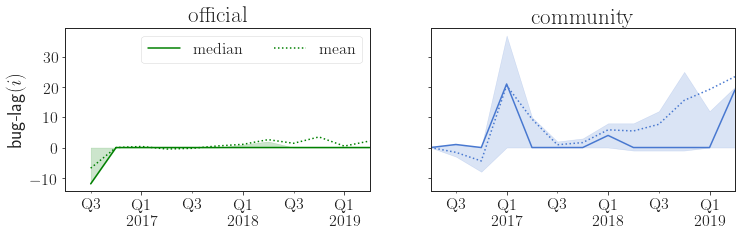

In [26]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(12,3)
for index, genre in enumerate(['official','community']):
    size=[12,20,70]
    df_=(image_bugs.
         query('type=="{}"'.format(genre)).
         groupby(pd.Grouper(key='last_updated', freq='1Q'))['cve_lag'].
         describe()[['mean', '25%', '50%', '75%']] 
        )

    df_tmp=df_
    df_tmp['50%'].rename('median').plot(ax=axes[index], color=colors[genre])
    ax=df_tmp['mean'].plot(ax=axes[index],style=':',color=colors[genre])
    ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], alpha=0.2, color=colors[genre])
    
    ax.set(
        xlabel='',
        ylabel=r'$\buglag(i)$',
        title=genre)
    plt.yticks(pd.np.arange(-10, 40, 10))
    ax.xaxis.set_minor_locator(minorLocator)
    ax.legend(prop={'size': 16}, ncol=2) 
ax.legend('').remove()

In [25]:
image_bugs.cve_lag.median()

0.0

In [27]:
# Mann-whitney u test
print(scipy.stats.mannwhitneyu(image_bugs.query('type=="community"').cve_lag, 
        image_bugs.query('type=="official"').cve_lag))

MannwhitneyuResult(statistic=449600690.0, pvalue=0.0)


In [28]:
# Mann-whitney u test
print(effect_size.cliffsDelta(image_bugs.query('type=="community"').cve_lag, 
        image_bugs.query('type=="official"').cve_lag))

d=0.26522554999687115
True


## Considering Debian release

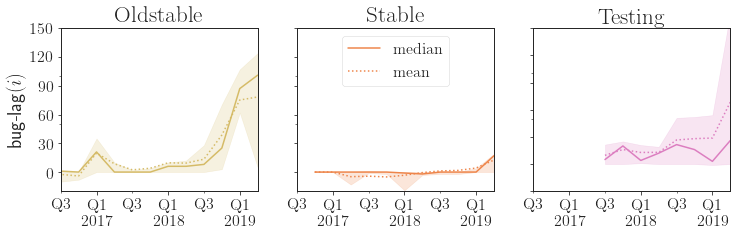

In [29]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)
fig.set_size_inches(12,3)
for index, genre in enumerate(['Oldstable','Stable','Testing']):
    size=[12,20,70]
    df_=(image_bugs.
         query('release=="{}"'.format(genre)).
         groupby(pd.Grouper(key='last_updated', freq='1Q'))['cve_lag'].
         describe()[['mean', '25%', '50%', '75%']] 
        )

    df_tmp=df_
    df_tmp['50%'].rename('median').plot(ax=axes[index], color=colors[genre])
    ax=df_tmp['mean'].plot(ax=axes[index],style=':',color=colors[genre])
    ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], alpha=0.2, color=colors[genre])
    
    ax.set(
        xlabel='',
        ylabel=r'$\buglag(i)$',
        title=genre,
        xlim=date_period,
        ylim=(-20,150))
    plt.yticks(pd.np.arange(-30, 180, 30))
    ax.xaxis.set_minor_locator(minorLocator)
    if index==1:
        ax.legend(loc='upper center', prop={'size': 16}, ncol=1)
    else:
        ax.legend('').remove()

In [30]:
# Mann-whitney u test
for x in [['Oldstable','Stable'], ['Oldstable','Testing'], ['Stable','Testing']]:
    print(x,scipy.stats.mannwhitneyu(image_bugs.query('release=="'+x[0]+'"').cve_lag, 
            image_bugs.query('release=="'+x[1]+'"').cve_lag))

['Oldstable', 'Stable'] MannwhitneyuResult(statistic=1383757316.0, pvalue=0.0)
['Oldstable', 'Testing'] MannwhitneyuResult(statistic=98932682.5, pvalue=2.7032195890549613e-16)
['Stable', 'Testing'] MannwhitneyuResult(statistic=97427538.0, pvalue=0.0)


In [31]:
# Mann-whitney u test
for x in [['Oldstable','Stable'], ['Oldstable','Testing'], ['Stable','Testing']]:
    print(x,effect_size.cliffsDelta(image_bugs.query('release=="'+x[0]+'"').cve_lag, 
            image_bugs.query('release=="'+x[1]+'"').cve_lag))

d=0.3858096517541738
['Oldstable', 'Stable'] True
d=-0.07690335177493829
['Oldstable', 'Testing'] False
d=-0.3762671362418918
['Stable', 'Testing'] True


In [32]:
for release in ['Testing','Stable','Oldstable']:
    print(release, image_bugs.query('release =="{}"'.format(release)).cve_lag.median())

Testing 13.0
Stable 0.0
Oldstable 5.0


## We check the evolution of bug lag using bug urgency

In [33]:
image_bugs['Lower'] = image_bugs['Lower'] - image_bugs['l_Lower']
image_bugs['Higher'] = image_bugs['Higher'] - image_bugs['l_Higher']

/home/neglectos/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


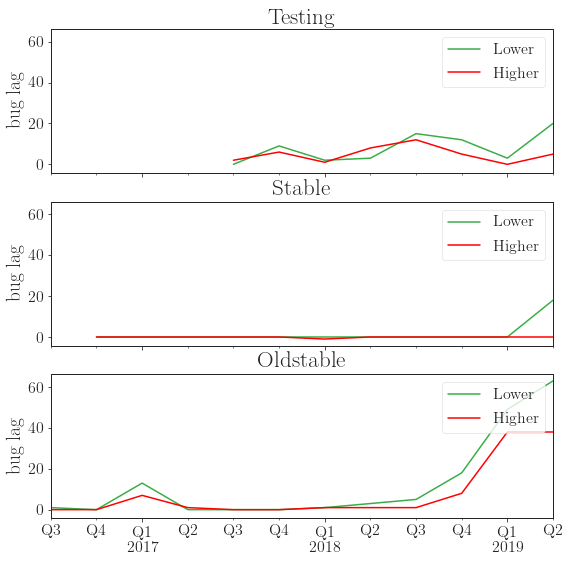

In [34]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True)
fig.set_size_inches(9,9)
for j, release in enumerate(['Testing','Stable','Oldstable']):
    df_=(image_bugs.
         query('release =="{}"'.format(release)).
         groupby(pd.Grouper(key='last_updated', freq='1Q'))[['Lower','Higher']].
         median()
        )
    color = colors[release]
    
    ax=df_.plot(ax=axes[j], colors=[colors[x] for x in ['Lower','Higher']])

    ax.set(
        xlabel='',
        #ylim=(0,20),
        ylabel='bug lag',
        title=release.capitalize(),    
        xlim=date_period)
    ax.legend(loc='upper right',  prop={'size': 16, 'weight':'bold'})


# Merge with vulnerability lag dataset and save the new dataset used to be reused an other time

In [45]:
all_lags = pd.read_csv('../../data/for_analysis/image_lags.csv', dtype=object)
all_lags.shape

(140496, 5)

In [46]:
all_lags = (all_lags
            .merge(image_bugs[['image','cve_lag']]
                   .rename(columns={"cve_lag":"bug_lag"}),
                   on = 'image',
                   how='left'
                  )
           )
all_lags.shape

(140496, 6)

In [50]:
all_lags.to_csv('../../data/for_analysis/image_lags.csv', index=False)